In [ ]:
import pandas as pd
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_files = r"/content/drive/MyDrive/Data_M/"

In [ ]:
data_hate = pd.read_pickle(f"{path_files}dataset_fr/data_hate.pkl")

In [ ]:
data_hate.head(10)

,HITId,tweet,sentiment,text length,clean_tweet_min,clean_tweet_std,clean_tweet_lem
0,1,rt @user personnage ainsi q tte la clique gauc...,1,128,personnage ainsi q tte la clique gauchiste deg...,personnag tte cliqu gauchist deguis 1 macron!!...,personnage tout cliqu gauchiste deguise 1 macr...
1,2,@user @user @user bah oui t'as raison l'autre ...,1,62,bah oui t'as raison l'autre c'est un mongol.,raison mongol.,raison mongol.
2,3,moi j'ai personne à qui m'adresser pour réclam...,1,120,moi j'ai personne à qui m'adresser pour réclam...,m'adress réclam. voisin attard pu brui adminis...,me adresser réclamer. voisin attarder puant br...
3,4,@user @user c...est vrai que les anchois sont ...,0,102,c ... est vrai que les anchois sont aller sur ...,... vrai anchois aller lun invent million tech...,... vrai anchois aller lune invent million tec...
4,5,eh les renois faut se réveiller la @url,0,39,eh les renois faut se réveiller la,renois faut réveil,renois falloir réveiller
5,6,@user @user en algerie les migrants sont expul...,1,112,en algerie les migrants sont expulsés dans le ...,alger migr expuls désert crois bien qu'vision,algerie migrant expulser désert croi bien que ...
6,7,@user sjw et féministe twitter un sale combo,0,44,sjw et féministe twitter un sale combo,sjw fémin twitt sal combo,sjw féministe twitter sale combo
7,8,@user @user tu sais aussi pourquoi est au dess...,0,101,tu sais aussi pourquoi est au dessus? parce qu...,sais? veut ya d'ani ...,sai? vouloir ya de ani ...
8,9,@user @user mytho t'as juste voulu te faire ke...,1,105,mytho t'as juste voulu te faire ken par les re...,mytho voulu fair ken renois lyc voulu to,mytho vouloir faire ken renois lycer vouloir to
9,10,c’est un giga attardé mdrrr ils va vraiment se...,1,64,c’est un giga attardé mdrrr ils va vraiment se...,gig attard mdrrr va fair shoot,giga-octet attarder mdrrr aller faire shoote


In [ ]:
target= data_hate["sentiment"]

In [ ]:
!pip install gensim==4.0
!pip install python-Levenshtein

In [ ]:
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
import numpy as np

In [ ]:
w2v = KeyedVectors.load(f"{path_files}w2v/w2vec_model_d300_global_Min")

In [ ]:
w2v.similar_by_word("noir")

[('blanc', 0.6659490466117859),
 ('noir,', 0.6475639343261719),
 ('blanc,', 0.6131015419960022),
 ('roux', 0.6044836640357971),
 ('noir.', 0.603306770324707),
 ('bandeau', 0.5998969674110413),
 ('marron', 0.5980905890464783),
 ('beige', 0.5841408967971802),
 ('blanc.', 0.5792201161384583),
 ('noir?', 0.575861930847168)]

In [ ]:
def encode(msg, model, dim):
    return np.mean([model[word] for word in msg if word in model] or [np.zeros(dim)], axis = 0)

In [ ]:
tweets=[line.split() for line in data_hate["clean_tweet_min"]]

In [ ]:
X=np.array([encode(msg, w2v, 300) for msg in tweets])

Appliquer SMOTE


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
model_lr = Pipeline([                                                
    ('classifier', LogisticRegression(C= 10,random_state=42,class_weight='balanced', max_iter= 10000))
])
SMOTE_pipeline = make_pipeline(SMOTE(random_state=777),model_lr)

In [ ]:
cv_results = cross_validate(SMOTE_pipeline, X, target, cv=5)
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score
0,0.467108,0.001536,0.637609
1,0.480905,0.001389,0.617684
2,0.527776,0.001255,0.631382
3,0.571195,0.001347,0.622665
4,0.566437,0.001318,0.655860


In [ ]:
cv_test_scores = cv_results['test_score']
print(
    "Accuracy globale avec SMOTE:\n"
    f"{cv_test_scores.mean():.3f} +/- {cv_test_scores.std():.3f}"
)

Generalization score with hyperparameters tuning:
0.633 +/- 0.015


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'pipeline__classifier__C': (0.1, 1,5)}
model_grid_search_lr = GridSearchCV(SMOTE_pipeline, param_grid=param_grid,
                                 n_jobs=2, cv=10)


In [ ]:
SMOTE_pipeline.get_params()

{'memory': None, 'pipeline': Pipeline(steps=[('classifier',
                  LogisticRegression(C=10, class_weight='balanced',
                                     max_iter=10000, random_state=42))]), 'pipeline__classifier': LogisticRegression(C=10, class_weight='balanced', max_iter=10000,
                    random_state=42), 'pipeline__classifier__C': 10, 'pipeline__classifier__class_weight': 'balanced', 'pipeline__classifier__dual': False, 'pipeline__classifier__fit_intercept': True, 'pipeline__classifier__intercept_scaling': 1, 'pipeline__classifier__l1_ratio': None, 'pipeline__classifier__max_iter': 10000, 'pipeline__classifier__multi_class': 'auto', 'pipeline__classifier__n_jobs': None, 'pipeline__classifier__penalty': 'l2', 'pipeline__classifier__random_state': 42, 'pipeline__classifier__solver': 'lbfgs', 'pipeline__classifier__tol': 0.0001, 'pipeline__classifier__verbose': 0, 'pipeline__classifier__warm_start': False, 'pipeline__memory': None, 'pipeline__steps': [('classifier'

In [ ]:
cv_result_lr = cross_validate(
    model_grid_search_lr, X, target, cv=5, n_jobs=2, return_estimator=True,error_score='raise'
)

In [ ]:
model_grid_search_lr.fit(X, target)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=777)),
                                       ('pipeline',
                                        Pipeline(steps=[('classifier',
                                                         LogisticRegression(C=10,
                                                                            class_weight='balanced',
                                                                            max_iter=10000,
                                                                            random_state=42))]))]),
             n_jobs=2, param_grid={'pipeline__classifier__C': (0.1, 1, 5)})

In [ ]:
model_grid_search_lr.best_params_

{'pipeline__classifier__C': 1}

In [ ]:
model_grid_search_lr.best_estimator_

Pipeline(steps=[('smote', SMOTE(random_state=777)),
                ('pipeline',
                 Pipeline(steps=[('classifier',
                                  LogisticRegression(C=1,
                                                     class_weight='balanced',
                                                     max_iter=10000,
                                                     random_state=42))]))])

In [ ]:
cv_result_lr = pd.DataFrame(cv_result_lr)
cv_test_scores = cv_result_lr['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} +/- {cv_test_scores.std():.3f}"
)

Generalization score with hyperparameters tuning:
0.634 +/- 0.019


très légère augmentation avec SMOTE, pour un double temps d'execution

In [ ]:
for cv_fold, estimator_in_fold in enumerate(cv_result_lr["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'pipeline__classifier__C': 5}
Best hyperparameters for fold #2:
{'pipeline__classifier__C': 5}
Best hyperparameters for fold #3:
{'pipeline__classifier__C': 1}
Best hyperparameters for fold #4:
{'pipeline__classifier__C': 5}
Best hyperparameters for fold #5:
{'pipeline__classifier__C': 5}


Choix du meilleur modèle

In [ ]:
model_lr = Pipeline([                                                 
    ('classifier', LogisticRegression(random_state=42,class_weight='balanced', max_iter= 100000,C=5))
])

In [ ]:
SMOTE_pipeline = make_pipeline(SMOTE(random_state=777),model_lr)

In [ ]:
cv_results = cross_validate(SMOTE_pipeline, X, target, cv=5)
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score
0,0.301102,0.001307,0.638854
1,0.421178,0.001677,0.613948
2,0.443466,0.001159,0.637609
3,0.388643,0.001175,0.627646
4,0.431444,0.001179,0.665835


In [ ]:
cv_test_scores = cv_results['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} +/- {cv_test_scores.std():.3f}")

Generalization score with hyperparameters tuning:
0.637 +/- 0.019


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred_smt = cross_val_predict(model_grid_search_lr.best_estimator_, X, target, cv=10)
conf_mat_smt = confusion_matrix(target, y_pred_smt)

In [ ]:
def draw_mat(conf_mat,title):
  print(title)
  matrice_proportions = np.zeros((2,2))
  for i in range(0,2):
      matrice_proportions[i,:] = conf_mat[i,:]/float(conf_mat[i,:].sum())
  names=['Neutre','Haineux']
  confusion_df = pd.DataFrame(matrice_proportions, index=names,columns=names)
  plt.figure(figsize=(5,5))
  sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
  plt.ylabel(r'Valeur réelle',fontsize=14)
  plt.xlabel(r'Valeur prédite',fontsize=14)
  plt.tick_params(labelsize=12)

matrice de confusion Regression logistique + SMOTE


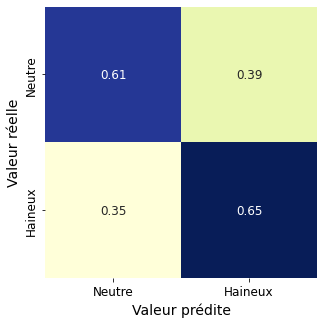

In [ ]:
draw_mat(conf_mat_smt, "matrice de confusion Regression logistique + SMOTE")

In [ ]:
model =LogisticRegression(C= 0.05,random_state=42,class_weight='balanced', max_iter= 10000)

In [ ]:
cv_result_lr = cross_validate(
    model, X, target, cv=5, n_jobs=-1, return_estimator=True,error_score='raise'
)

In [ ]:
y_pred = cross_val_predict(model, X, target, cv=10)
conf_mat = confusion_matrix(target, y_pred)

matrice de confusion Regression logistique


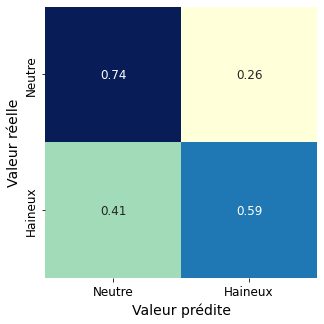

In [ ]:
draw_mat(conf_mat, "matrice de confusion Regression logistique")

On remarque que les résultats de la regression logistique sans réequilibrage avec SMOTE sont meilleures qu'avec.